# Lecture 08: A Simple Decision-Making Circuit

In [1]:
%matplotlib inline

# import packages
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
sns.set_palette('husl')

# allow inline plotting in the notebook
# resize plots for this exercise
plt.rcParams['figure.figsize'] = (12, 8)

# start scope for this brian2 simulation
start_scope()

In [2]:
# define equations for the AdEx model (include noise)
# and equations for the AMPA and GABA synapse models
eqs =  '''
du/dt = ( -(u - u_rest) + delta_T*exp((u-vartheta_rh)/delta_T) \
    + R*(I - w - I_AMPA - I_GABA) ) / tau_m + sigma*xi*tau_m**-0.5 : volt
dw/dt = (a*(u - u_rest) - w)/tau_w : amp
I = input_current(t,i) : amp
I_AMPA = g_AMPA*(u - E_AMPA): amp
I_GABA = g_GABA*(u - E_GABA): amp
dg_AMPA/dt = -g_AMPA / tau_AMPA : siemens
dg_GABA/dt = -g_GABA / tau_GABA : siemens
'''

In [3]:
# excitatory synapses
E_AMPA = 0 * mV  # equilibrium potential of the channe
tau_AMPA = 2 * ms  # speed of NT unbinding
AMPA_jump_large = 100 * nsiemens  # jump in conductivity for strong exc
AMPA_jump_small = 0 * nsiemens  # jump in conductivity for weak excit

# inhibitory synapses
E_GABA = -70 * mV  # equilibrium potential of the channel
tau_GABA = 6 * ms  # speed of NT unbinding
GABA_jump = 0 * nsiemens  # jump in conductivity for inhibitory synapse

In [4]:
# create neuron group
RSN = NeuronGroup(2, eqs, threshold='u>theta_reset',
                  reset='u=u_r; w+= b')

In [5]:
# define parameters of the RSN AdEx model
RSN.namespace['R'] = 200*Mohm  # membrane resistance
RSN.namespace['tau_m'] = 24*ms  # membrane time constant
RSN.namespace['theta_reset'] = 35*mV  # reset threshold
RSN.namespace['u_rest'] = -65*mV  # resting potential
RSN.namespace['u_r'] = -55*mV  # reset potential
RSN.namespace['vartheta_rh'] = -52*mV  # rheobase threshold
RSN.namespace['delta_T'] = 0.8*mV  # sharpness of the action poten
RSN.namespace['tau_w'] = 88*ms  # adaptation time constant
RSN.namespace['a'] = -0.8*nS  # subthreshold adaptation const
RSN.namespace['b'] = 65*pamp  # adaptation jump after a spike
RSN.namespace['sigma'] = 0*mV  # amplitude of noise added to t

In [6]:
# set initial potential to u_rest
# use the variable in this model's namespace (see below)
RSN.u[:] = -65 * mV

# set initial adaptation to zero
RSN.w[:] = 0

In [7]:
# create 1000x2 array of zeros
# each column in this array will be input for a different neuron
input_current = np.zeros((1000, 2))

# place an input of 200 pA to the first neuron (with index 0)
# starting at t=101 and ending at t=1000
input_current[100:1000, 0] = 400

# convert numpy array to timed array
input_current = TimedArray(input_current*pamp, dt=1*ms)

# place in model's namespace
RSN.namespace['input_current'] = input_current

In [8]:
# create neuron group
MSN = NeuronGroup(2, eqs, threshold='u>theta_reset',
                  reset='u=u_r; w+= b')

In [9]:
# define parameters of the MSN AdEx model
MSN.namespace['R'] = 31.5*Mohm  # membrane resistance
MSN.namespace['tau_m'] = 50*ms  # membrane time constant
MSN.namespace['theta_reset'] = 40*mV  # reset threshold
MSN.namespace['u_rest'] = -80*mV  # resting potential
MSN.namespace['u_r'] = -55*mV  # reset potential
MSN.namespace['vartheta_rh'] = -55*mV  # rheobase threshold
MSN.namespace['delta_T'] = 2*mV  # sharpness of the action poten
MSN.namespace['tau_w'] = 100*ms  # adaptation time constant
MSN.namespace['a'] = -20*nS  # subthreshold adaptation const
MSN.namespace['b'] = 150*pamp  # adaptation jump after a spike
MSN.namespace['sigma'] = 0*mV  # amplitude of noise added to t

In [10]:
# set initial potential to u_rest
# use the variable in this model's namespace (see below)
MSN.u[:] = -80*mV

# set initial adaptation to zero
MSN.w[:] = 0

In [11]:
# create 1000x2 array of zeros
# each column in this array will be input for a different neuron
input_current = np.zeros((1000,4))

# convert numpy array to timed array
input_current = TimedArray(input_current*pamp, dt=1*ms)
MSN.namespace['input_current'] = input_current

# let's get rid of input_current to avoid namespace warnings
del input_current

In [12]:
# create strong excitatory synapses
E_strong = Synapses(RSN, MSN, on_pre='g_AMPA += AMPA_jump_large')
E_strong.connect(i=0,j=0)
E_strong.connect(i=1,j=1)

In [13]:
# create weak excitatory synapses
E_weak = Synapses(RSN, MSN, on_pre='g_AMPA += AMPA_jump_small')
E_weak.connect(i=0,j=1)
E_weak.connect(i=1,j=0)

In [14]:
# create inhibitory synapses
I = Synapses(MSN, on_pre='g_GABA += GABA_jump')
I.connect(i=0,j=1)
I.connect(i=1,j=0)

In [15]:
def plot_this(a, b, this='g_AMPA',
          y_min=-100, y_max=0, y_unit=nsiemens):
        
    def roundup(x):
        return int(math.ceil((x+5) / 20.0)) * 20
    
    def rounddown(x):
        return int(math.floor((x-5) / 20.0)) * 20
    
    vals = np.array([a.u[0]/mV, a.u[1]/mV, b.u[0]/mV, b.u[1]/mV])
    
    y_min = rounddown(np.min(vals))
    y_max = roundup(np.max(vals))
    
    plt.subplot(2,2,1)
    axes = plt.gca()
    axes.set_ylim([y_min, y_max])
    plot(a.t*1000, a.u[0]/mV, color=sns.color_palette('husl')[2])
    plt.ylabel('Membrane potential (mV)')
    plt.xlabel('')
    plt.title('RSN 0: Green Input')

    plt.subplot(2,2,2)
    axes = plt.gca()
    axes.set_ylim([y_min,y_max])
    plot(a.t*1000, a.u[1]/mV, color=sns.color_palette('husl')[0])
    plt.ylabel('')
    plt.xlabel('')
    plt.title('RSN 1: Red Input')
    
    plt.subplot(2,2,3)
    axes = plt.gca()
    axes.set_ylim([y_min, y_max])
    plot(b.t*1000, b.u[0]/mV, color=sns.color_palette('husl')[3])
    plt.ylabel('Membrane potential (mV)')
    plt.xlabel('Time (ms)')
    plt.title('MSN 0: Go Left')

    plt.subplot(2,2,4)
    axes = plt.gca()
    axes.set_ylim([y_min,y_max])
    plot(b.t*1000, b.u[1]/mV, color=sns.color_palette('husl')[4])
    plt.ylabel('')
    plt.xlabel('Time (ms)')
    plt.title('MSN 1: Go Right')
    
    plt.tight_layout()
    plt.show()

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.11s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.04s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


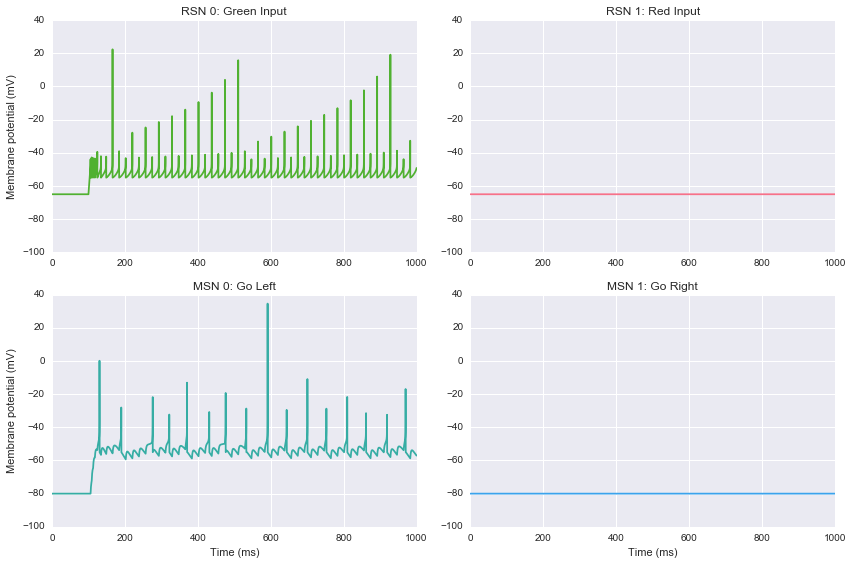

In [16]:
# indicate what to record
rec_RSN = StateMonitor(RSN, ('I', 'u', 'w','I_AMPA',
          'I_GABA', 'g_GABA', 'g_AMPA'), record=True)
rec_MSN = StateMonitor(MSN, ('I','u', 'w', 'I_AMPA',
          'I_GABA', 'g_GABA', 'g_AMPA'), record=True)
# run the simulation for 1000 ms+
store()
run(1000*ms)

plot_this(rec_RSN, rec_MSN)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.04s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.04s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


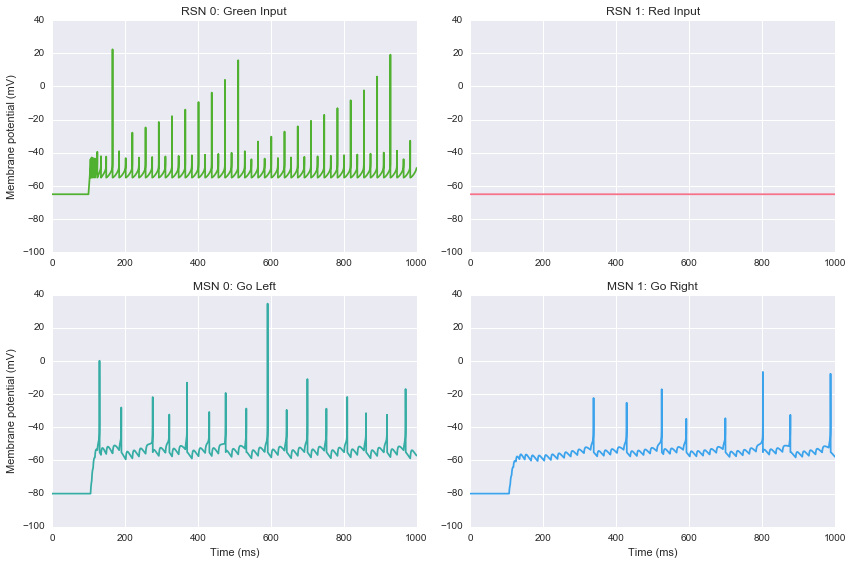

In [17]:
# give a value to the small excitatory synapses
AMPA_jump_small = 70*nsiemens
# restore the model to what it was before running
restore()
# run the simulation for 1000 ms
run(1000*ms)
# plot membrane potential
plot_this(rec_RSN, rec_MSN)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.04s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.05s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


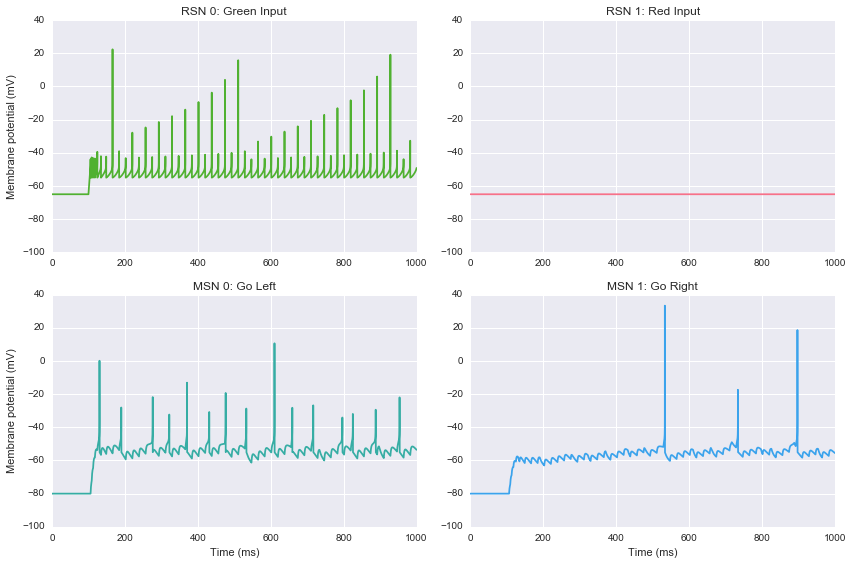

In [18]:
# give a value to the small excitatory synapses
GABA_jump = 70*nsiemens
# restore the model to what it was before running
restore()
# run the simulation for 1000 ms
run(1000*ms)
# plot membrane potential
plot_this(rec_RSN, rec_MSN)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.04s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.04s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


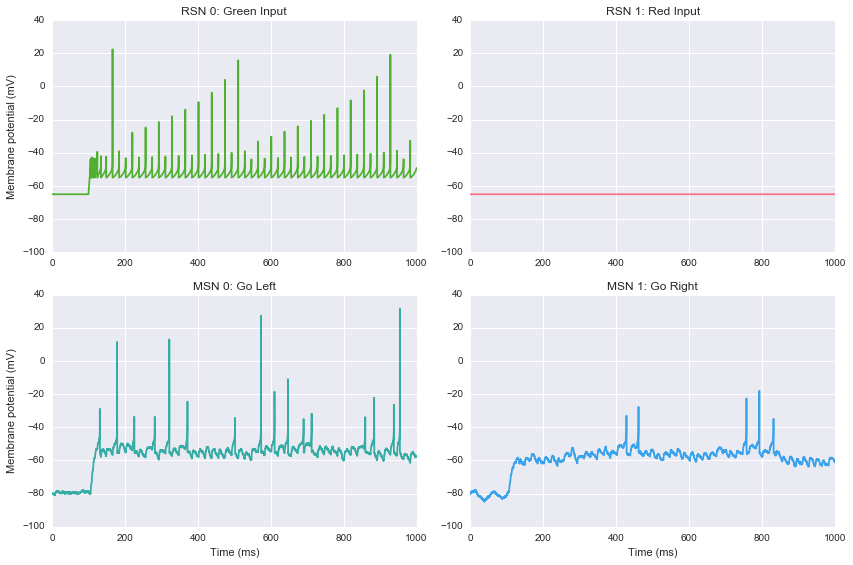

In [19]:
# give a value to the standard deviation of the noise in MSN neurons
MSN.namespace['sigma'] = 3*mV
# restore the model to what it was before running
restore()
# run the simulation for 1000 ms
run(1000*ms)
# plot membrane potential
plot_this(rec_RSN, rec_MSN)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.05s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.05s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


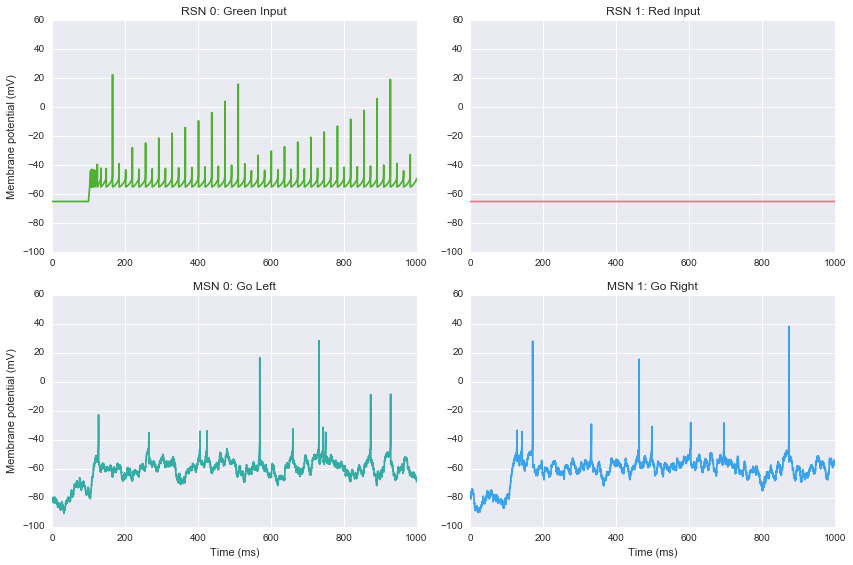

In [20]:
# give a value to synaptic conductances
GABA_jump = 100*nsiemens
AMPA_jump_large = 100*nsiemens
AMPA_jump_small = 100*nsiemens
# add a lot of noise
MSN.namespace['sigma'] = 10*mV
# restore the model to what it was before running
restore()
# run the simulation for 1000 ms
run(1000*ms)
# plot membrane potential
plot_this(rec_RSN, rec_MSN)